In [1]:
import numpy as np 
import pandas as pd 

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import StratifiedShuffleSplit, KFold, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import skew

from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression,Ridge,Lasso, RidgeCV, ElasticNet, ElasticNetCV, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn import preprocessing
import xgboost as xgb
import lightgbm as lgb

import os

import warnings

pd.set_option('max_columns', 200)

ModuleNotFoundError: No module named 'xgboost'

In [43]:
%matplotlib inline
os.chdir('C:\\Users\\haju1\\OneDrive\\Documents\\COURS\\Cours 3A\\Testetprojets\\House pricing')
train = pd.read_excel('boston_corrected.xlsx')
train.head()

,TOWN,TOWNNO,TRACT,LON,LAT,MEDV,CMEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,Nahant,0,2011,-70.955,42.2550,24.0,24.0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98
1,Swampscott,1,2021,-70.950,42.2875,21.6,21.6,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14
2,Swampscott,1,2022,-70.936,42.2830,34.7,34.7,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03
3,Marblehead,2,2031,-70.928,42.2930,33.4,33.4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94
4,Marblehead,2,2032,-70.922,42.2980,36.2,36.2,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33


# EDA

In [3]:
train.shape

(506, 20)

In [4]:
train.dtypes

TOWN        object
TOWNNO       int64
TRACT        int64
LON        float64
LAT        float64
MEDV       float64
CMEDV      float64
CRIM       float64
ZN         float64
INDUS      float64
CHAS         int64
NOX        float64
RM         float64
AGE        float64
DIS        float64
RAD          int64
TAX          int64
PTRATIO    float64
B          float64
LSTAT      float64
dtype: object

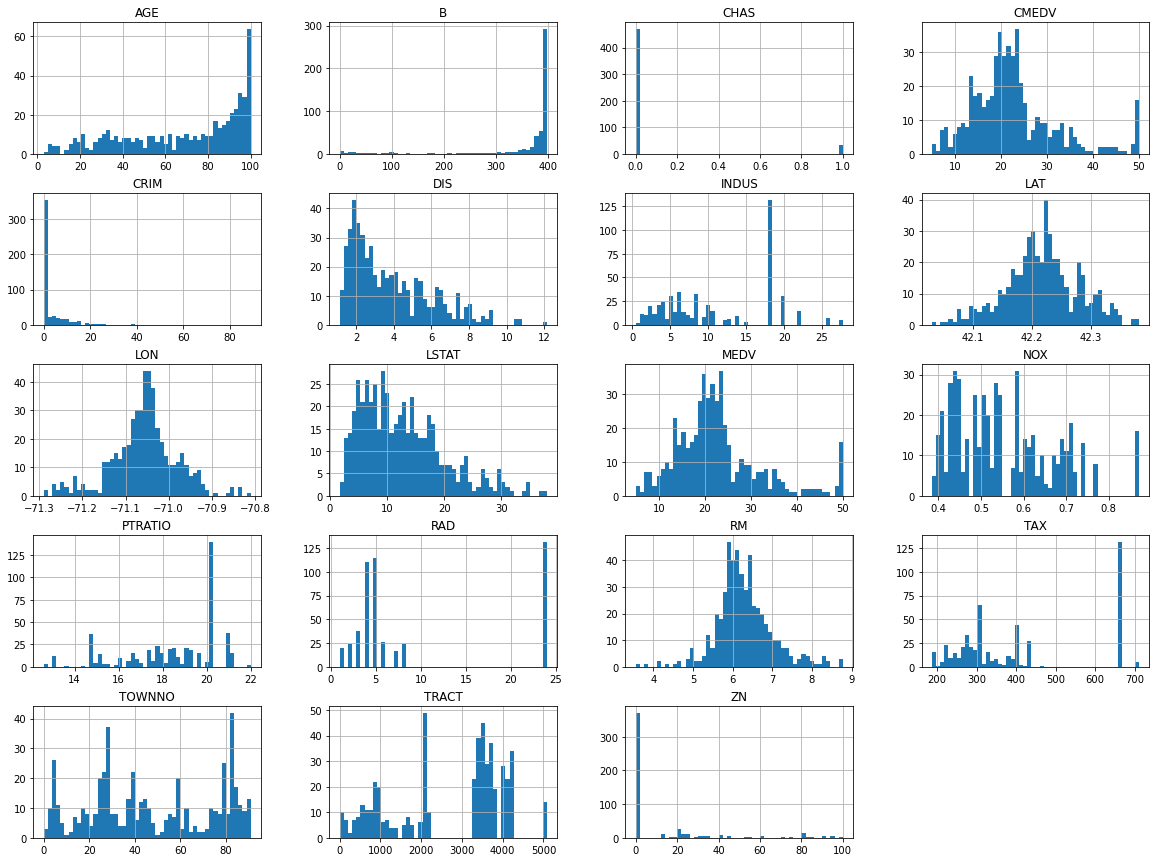

In [5]:
train.hist(bins = 50,figsize=(20,15))
plt.show()

In [6]:
def list_missing(data, verbose=True):
    mis_cols = [col for col in data.columns if data[col].isna().any()]
    if not verbose:
        return mis_cols
    tot_rows = len(data)
    for col in mis_cols:
        print(f'Column {col}: {round(data[col].isna().sum()*100/tot_rows, 2)}% missing')
    return mis_cols

In [7]:
mis_cols = list_missing(train)

In [8]:
def plot_correlations(data, target=None, limit=50, figsize=(12,10), **kwargs):
    '''
    This function  plots the correlation matrix of a dataframe
    If a target feature is provided, it will display only a certain amount of features, the ones correlated the most
    with the target. The number of features displayed is controlled by the parameter limit
    '''
    corr = data.corr()
    if target:
        corr['abs'] = abs(corr[target])
        cor_target = corr.sort_values(by='abs', ascending=False)[target]
        cor_target = cor_target[:limit]
        del corr['abs']
        corr = corr.loc[cor_target.index, cor_target.index]
    plt.figure(figsize=figsize)
    ax = sns.heatmap(corr, cmap='RdBu_r', **kwargs)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    return cor_target


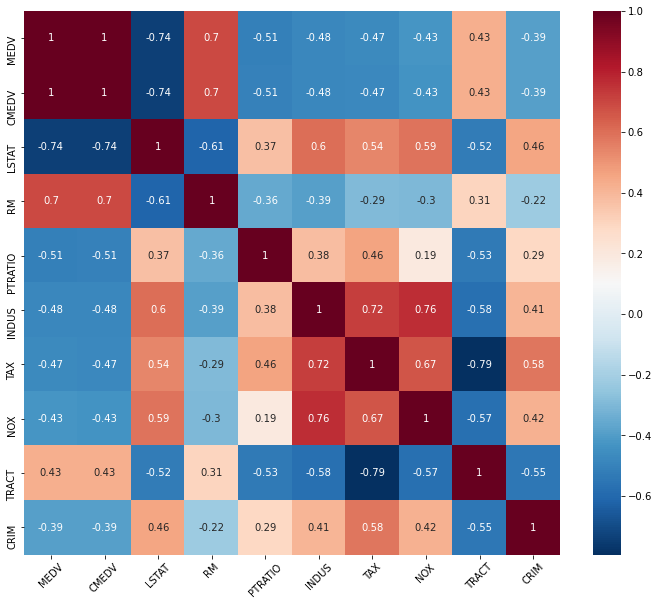

In [9]:
high_corr = plot_correlations(train, 'MEDV', limit=10, annot=True)

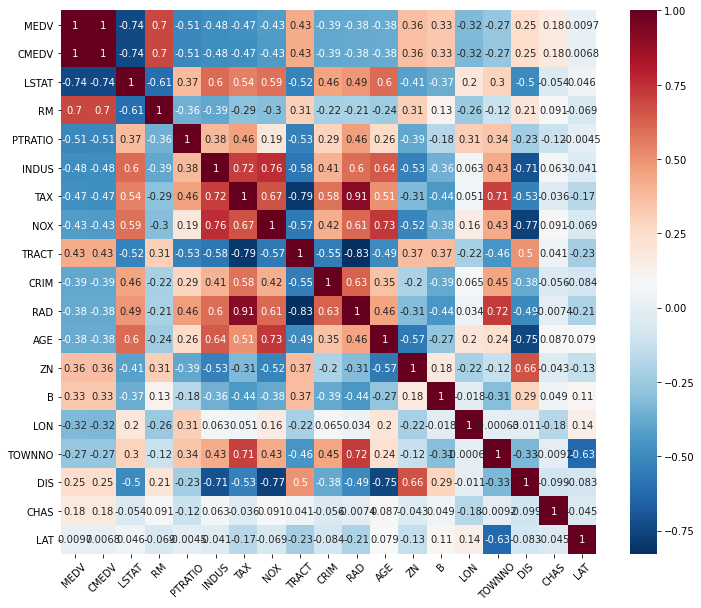

In [11]:
high_corr = plot_correlations(train, 'MEDV', limit=20 , annot = True)

In [12]:
def plot_distribution(data, column, bins=50, correlation=None):
    '''
    Plots a histogram of a given column
    If a Pandas Series is provided with the correlation values, it will be displayed in the title.
    '''
    plt.figure(figsize=(12,8))
    data[column].hist(bins=bins)
    if not correlation is None:
        value = correlation[column]
        column = column + f' - {round(value,2)}'
    plt.title(f'Distribution of {column}', fontsize=18)
    plt.grid(False)

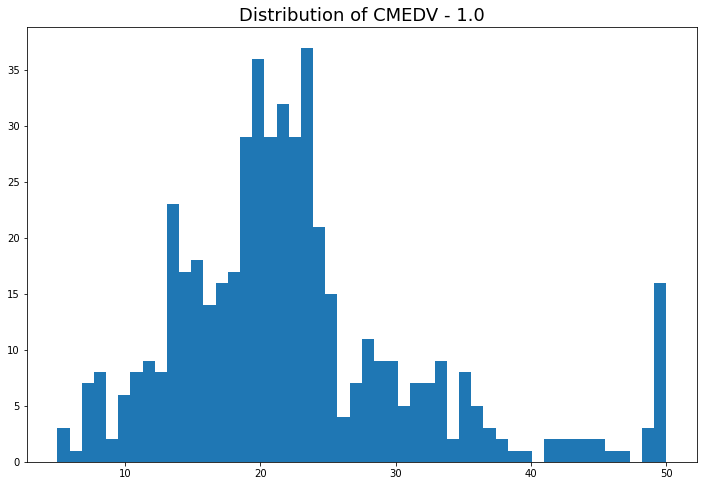

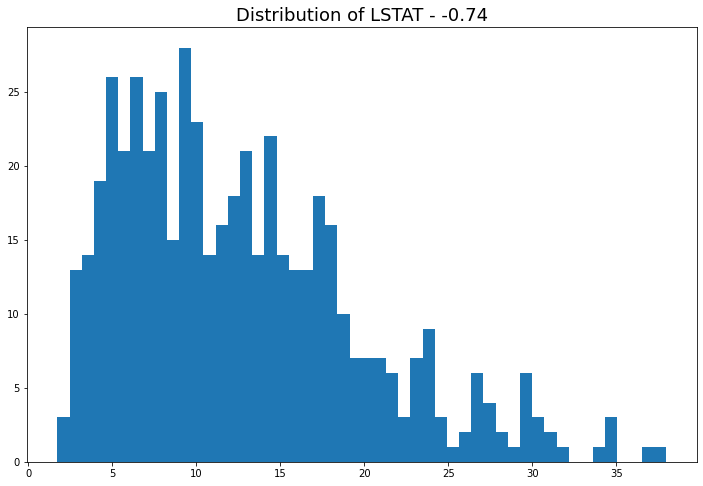

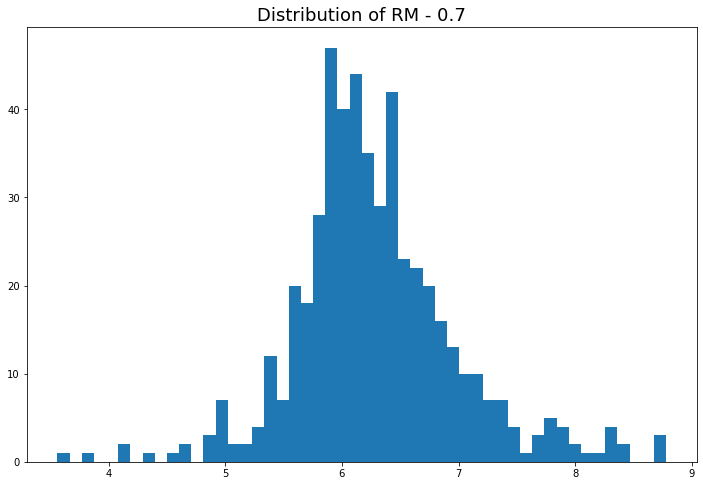

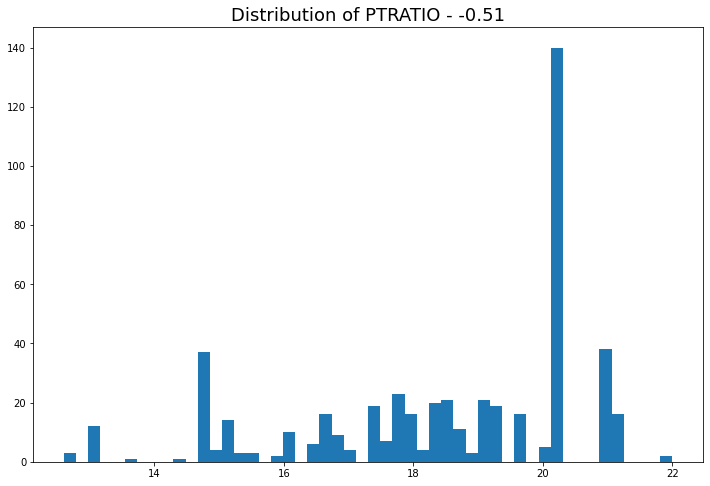

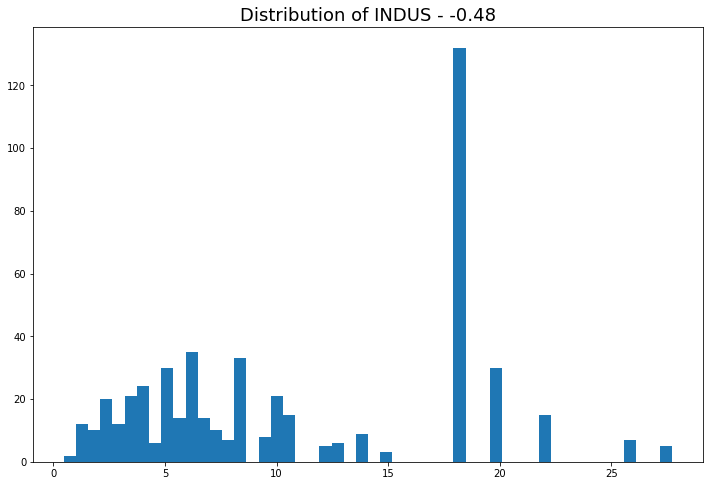

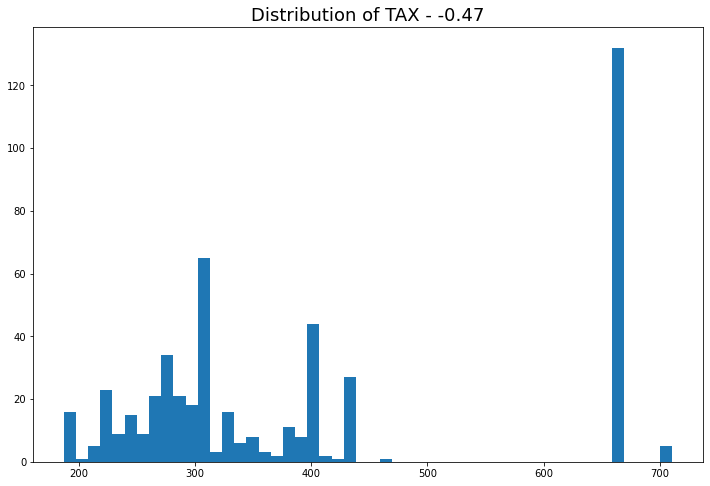

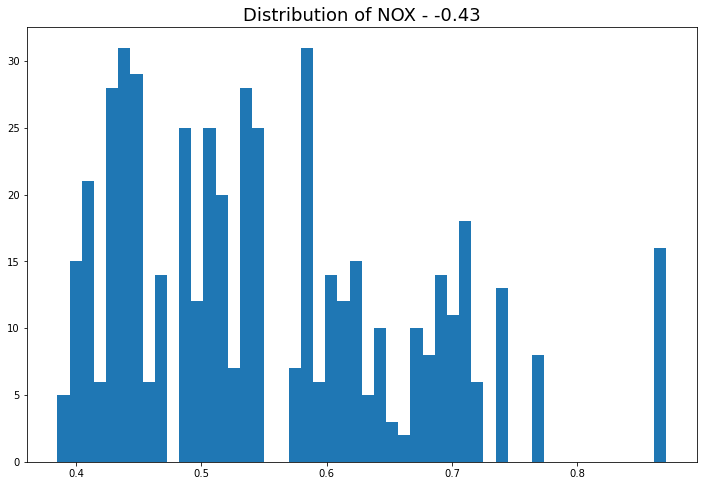

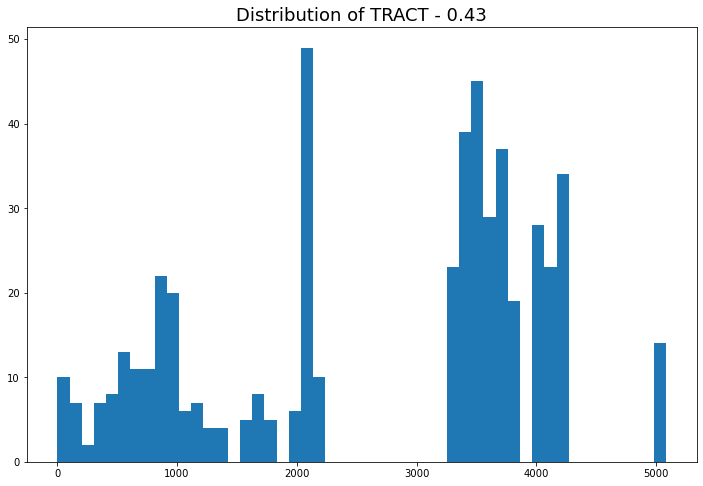

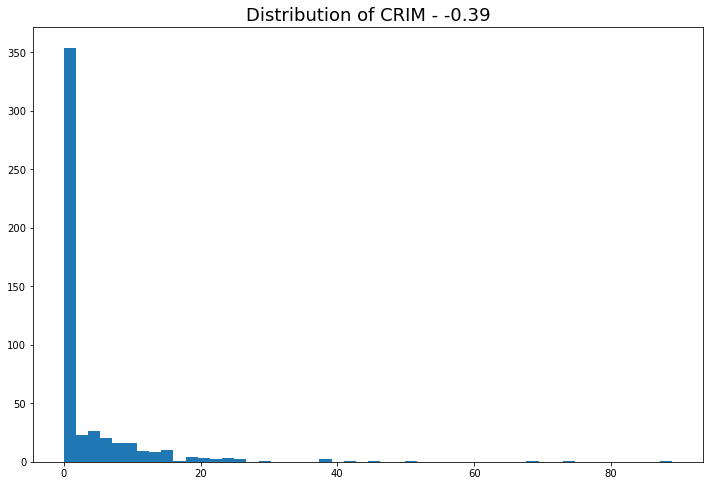

In [13]:
for col in high_corr[1:10].index:
    plot_distribution(train, col, correlation=high_corr)

In [14]:
def corr_target(data, target, cols, x_estimator=None):
    '''
    Scatterplot + linear regression of a list of columns against the target.
    A correlation matrix is also printed.
    It is possible to pass an estimator.
    '''
    print(data[cols+[target]].corr())
    num = len(cols)
    rows = int(num/2) + (num % 2 > 0)
    cols = list(cols)
    y = data[target]
    fig, ax = plt.subplots(rows, 2, figsize=(12, 5 * (rows)))
    i = 0
    j = 0
    for feat in cols:
        x = data[feat]
        if (rows > 1):
            sns.regplot(x=x, y=y, ax=ax[i][j], x_estimator=x_estimator)
            j = (j+1)%2
            i = i + 1 - j
        else:
            sns.regplot(x=x, y=y, ax=ax[i], x_estimator=x_estimator)
            i = i+1


            CMEDV     LSTAT        RM   PTRATIO     INDUS       TAX       NOX  \
CMEDV    1.000000 -0.740836  0.696304 -0.505655 -0.484754 -0.471979 -0.429300   
LSTAT   -0.740836  1.000000 -0.613808  0.374044  0.603800  0.543993  0.590879   
RM       0.696304 -0.613808  1.000000 -0.355501 -0.391676 -0.292048 -0.302188   
PTRATIO -0.505655  0.374044 -0.355501  1.000000  0.383248  0.460853  0.188933   
INDUS   -0.484754  0.603800 -0.391676  0.383248  1.000000  0.720760  0.763651   
TAX     -0.471979  0.543993 -0.292048  0.460853  0.720760  1.000000  0.668023   
NOX     -0.429300  0.590879 -0.302188  0.188933  0.763651  0.668023  1.000000   
TRACT    0.428252 -0.522486  0.305207 -0.532679 -0.575706 -0.793603 -0.569808   
CRIM    -0.389582  0.455621 -0.219247  0.289946  0.406583  0.582764  0.420972   
RAD     -0.384766  0.488676 -0.209847  0.464741  0.595129  0.910228  0.611441   
AGE     -0.377999  0.602339 -0.240265  0.261515  0.644779  0.506456  0.731470   
MEDV     0.998476 -0.737663 

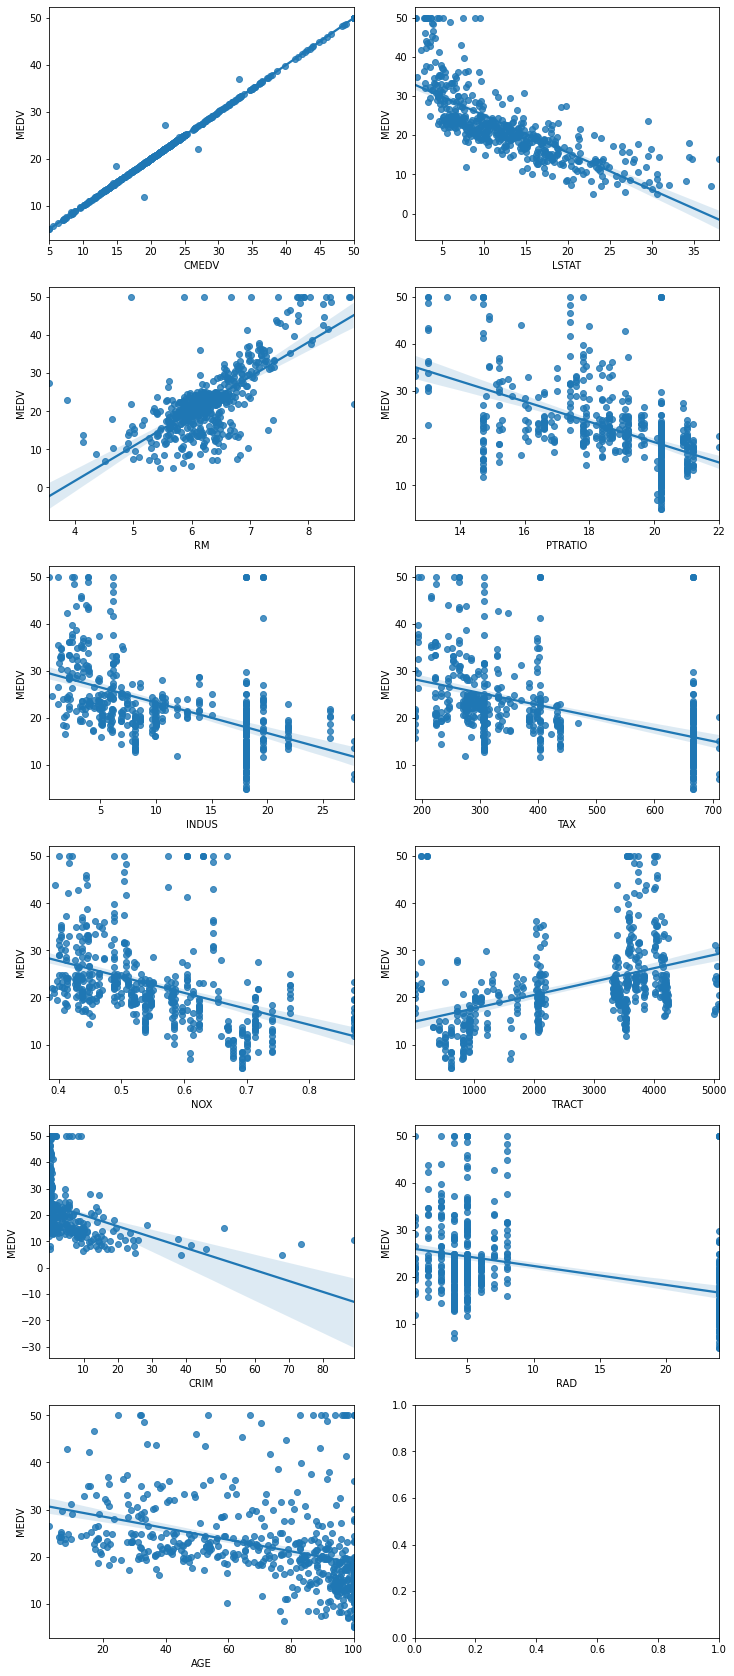

In [17]:
corr_target(train, 'MEDV', list(high_corr[1:12].index))

In [18]:
def segm_target(data, cat, target):
    '''
    Studies the target segmented by a categorical feature.
    It plots both a boxplot and a distplot for visual support
    '''
    
    df = data.groupby(cat)[target].agg(['count', 'mean', 'max', 
                                        'min', 'median', 'std'])
    fig, ax = plt.subplots(1,2, figsize=(12, 5))
    sns.boxplot(cat, target, data=data, ax=ax[0])
    for val in data[cat].unique():
        tmp = data[data[cat] == val]
        sns.distplot(tmp[target], hist=False, kde=True,
                 kde_kws = {'linewidth': 3},
                 label = val, ax=ax[1])  
    return df


c:\users\haju1\appdata\local\programs\python\python36\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
c:\users\haju1\appdata\local\programs\python\python36\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
c:\users\haju1\appdata\local\programs\python\python36\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
c:\users\haju1\appdata\local\programs\python\python36\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
c:\users\haju1\appdata\local\programs\python\python36\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kern

,count,mean,max,min,median,std
TOWNNO,,,,,,
0,1,24.000000,24.0,24.0,24.00,NaN
1,2,28.150000,34.7,21.6,28.15,9.263099
2,3,32.766667,36.2,28.7,33.40,3.789899
3,7,20.142857,27.1,15.0,18.90,4.107658
4,22,16.713636,23.1,12.7,16.10,3.068472
...,...,...,...,...,...,...
87,4,23.375000,25.0,21.8,23.35,1.337597
88,4,20.375000,21.2,19.1,20.60,0.895824
89,5,12.800000,20.1,7.0,13.60,5.371685


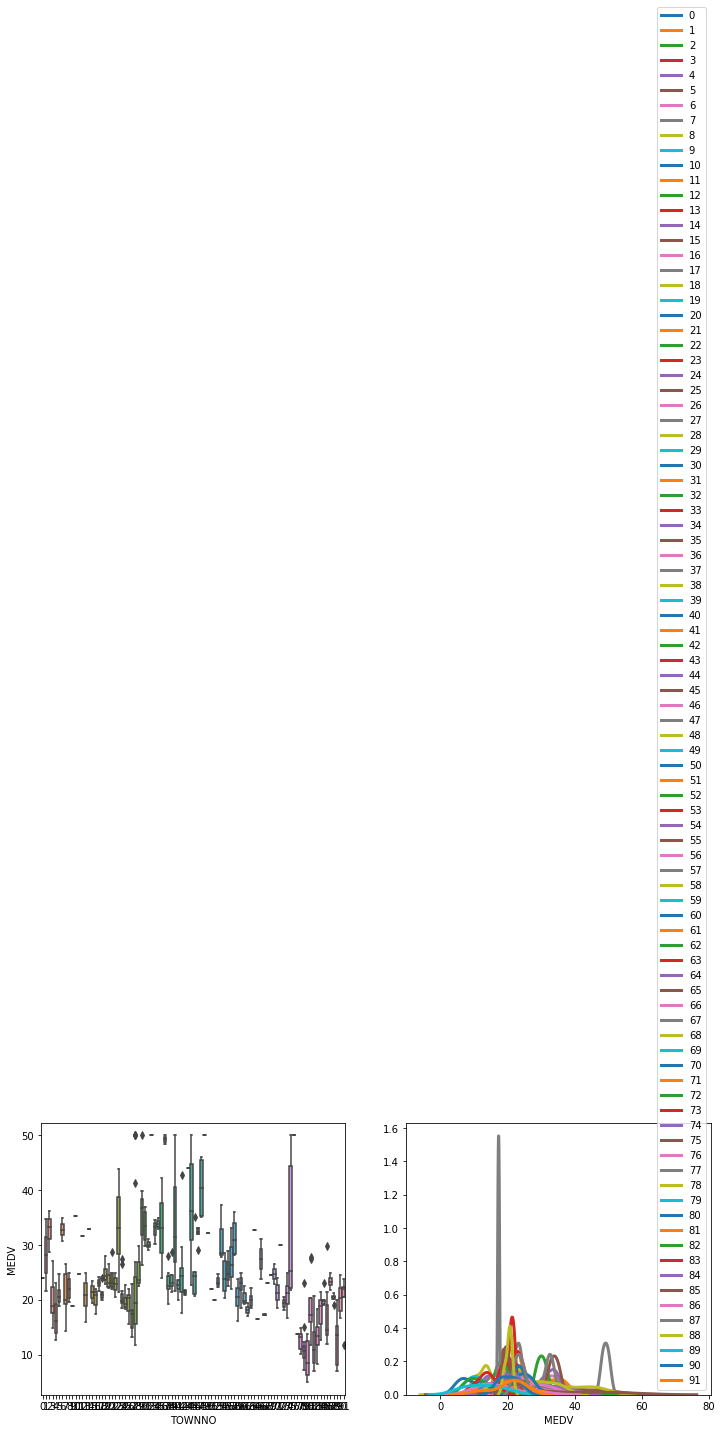

In [20]:
segm_target(train, 'TOWNNO', 'MEDV')

,count,mean,max,min,median,std
RAD,,,,,,
1,20,24.365000,50.0,11.9,22.20,8.024454
2,24,26.833333,43.8,15.7,23.85,7.874376
3,38,27.928947,50.0,14.4,26.50,8.324692
4,110,21.387273,50.0,7.0,20.45,6.957883
5,115,25.706957,50.0,11.8,23.00,9.328401
6,26,20.976923,24.8,16.8,21.20,2.312801
7,17,27.105882,42.8,17.6,26.20,6.493215
8,24,30.358333,50.0,16.0,28.25,9.727724
24,132,16.403788,50.0,5.0,14.40,8.539745


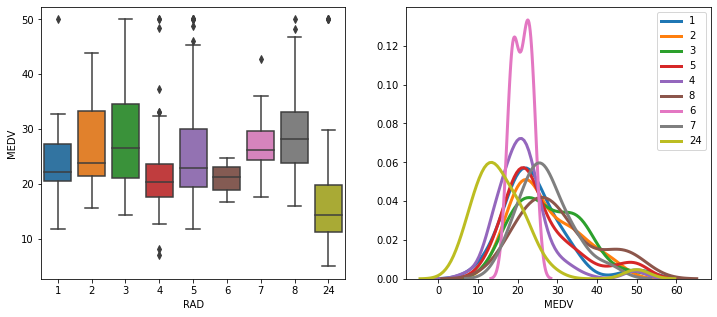

In [25]:
segm_target(train, 'RAD', 'MEDV')

,count,mean,max,min,median,std
CHAS,,,,,,
0,471,22.093843,50.0,5.0,20.9,8.831362
1,35,28.440000,50.0,13.4,23.3,11.816643


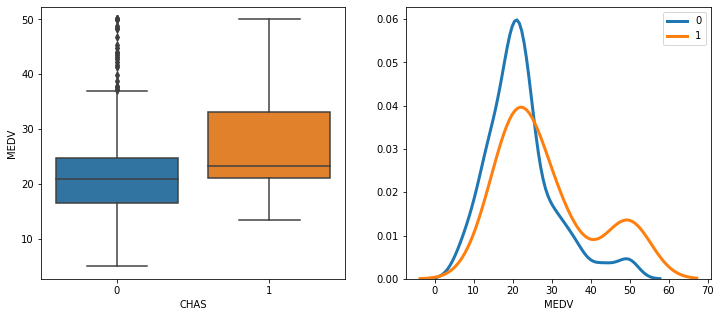

In [22]:
segm_target(train, 'CHAS', 'MEDV')

c:\users\haju1\appdata\local\programs\python\python36\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
c:\users\haju1\appdata\local\programs\python\python36\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
c:\users\haju1\appdata\local\programs\python\python36\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
c:\users\haju1\appdata\local\programs\python\python36\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
c:\users\haju1\appdata\local\programs\python\python36\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kern

,count,mean,max,min,median,std
TAX,,,,,,
187,1,30.100000,30.1,30.1,30.1,NaN
188,7,19.428571,22.0,15.7,20.3,2.281603
193,8,36.200000,50.0,26.4,36.7,7.177146
198,1,50.000000,50.0,50.0,50.0,NaN
216,5,38.980000,46.0,33.0,35.4,6.207415
...,...,...,...,...,...,...
432,9,19.688889,22.8,18.3,19.2,1.498703
437,15,17.093333,23.0,13.3,17.4,2.560543
469,1,18.900000,18.9,18.9,18.9,NaN


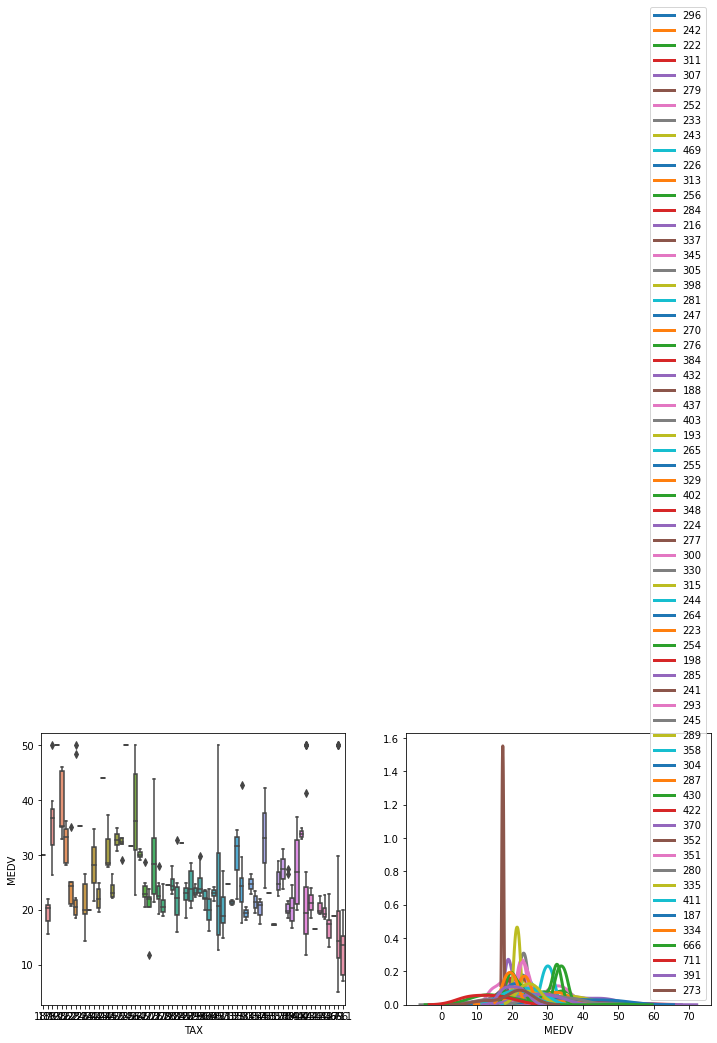

In [24]:
segm_target(train, 'TAX', 'MEDV')

# Prediction

In [44]:
target = train.MEDV

In [45]:
del train['TOWN']
del train['MEDV']
del train['CMEDV']

In [39]:
train.head()

,TOWNNO,TRACT,LON,LAT,CMEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0,2011,-70.955,42.2550,24.0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98
1,1,2021,-70.950,42.2875,21.6,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14
2,1,2022,-70.936,42.2830,34.7,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03
3,2,2031,-70.928,42.2930,33.4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94
4,2,2032,-70.922,42.2980,36.2,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33


### LINEAR MODEL

### SCORE

In [46]:
n_folds = 5

def rmsle_cv(model,X,y):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X.values)
    rmse= np.sqrt(-cross_val_score(model, X.values, y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [47]:
lm = LinearRegression()
cv_lm = rmsle_cv(lm,train,target).mean()
cv_lm

6.765966873915009

Text(0.5, 1.0, 'Coefficients in the Linear Model')

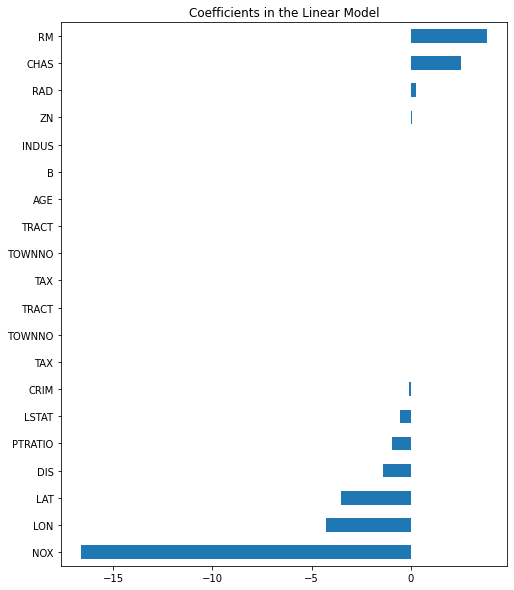

In [48]:
model_lm = LinearRegression().fit(train, target)
coef = pd.Series(model_lm.coef_, index = train.columns)
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Linear Model")

### Ridge Model

In [49]:
alphas = [0.0001,0.001,0.01,0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge=[]
for alpha in alphas : 
    ridge = Ridge(alpha = alpha)
    cv_ridge.append(rmsle_cv(ridge,train,target).mean())

Text(0, 0.5, 'rmsle')

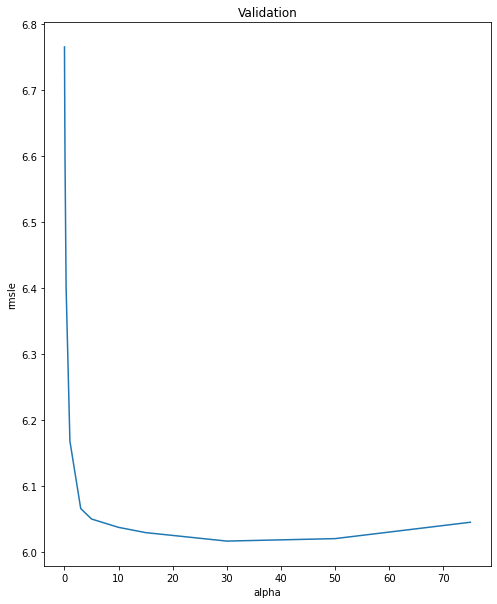

In [50]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation")
plt.xlabel("alpha")
plt.ylabel("rmsle")

In [51]:
cv_ridge.min()

6.0168264264485725

In [52]:
min_alpha_ridge = np.argmin(cv_ridge)
min_alpha_ridge

11

Text(0.5, 1.0, 'Coefficients in the Ridge Model')

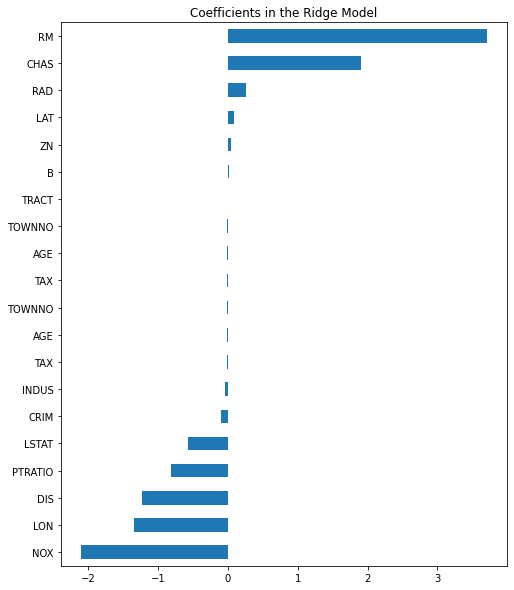

In [53]:
model_ridge = RidgeCV(alphas = [min_alpha_ridge]).fit(train, target)
coef = pd.Series(model_ridge.coef_, index = train.columns)
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")

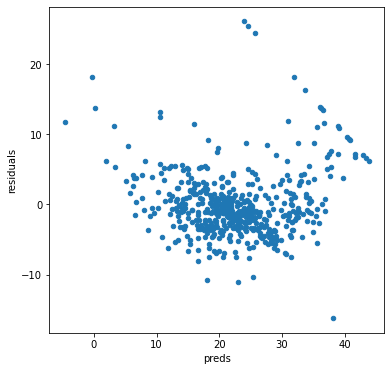

In [55]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":model_ridge.predict(train), "true":target})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

### Lasso Model

Text(0, 0.5, 'rmsle')

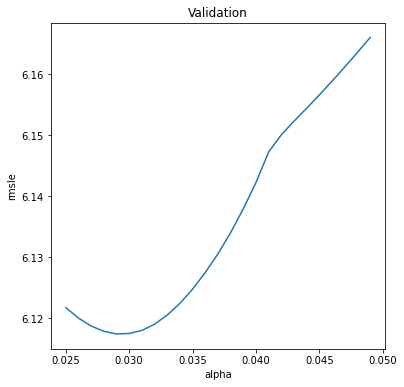

In [62]:
alphas = np.arange(0.025,0.05,0.001)
cv_lasso=[]
for alpha in alphas : 
    lasso = Lasso(alpha = alpha)
    cv_lasso.append(rmsle_cv(lasso,train,target).mean())
cv_lasso = pd.Series(cv_lasso, index = alphas)
cv_lasso.plot(title = "Validation")
plt.xlabel("alpha")
plt.ylabel("rmsle")

In [63]:
cv_min = cv_lasso.min()
cv_min

6.117428481068576

In [64]:
min_alpha_lasso = np.argmin(cv_lasso)
min_alpha_lasso

4

Lasso picked 6 variables and eliminated the other 11 variables


Text(0.5, 1.0, 'Coefficients in the Lasso Model')

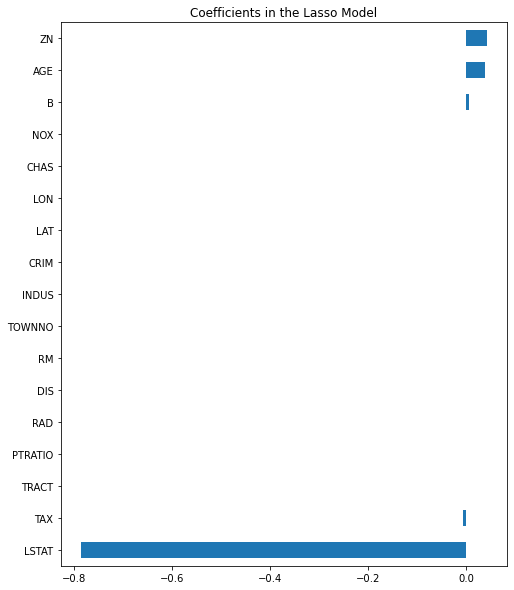

In [68]:
model_lasso = LassoCV(alphas = [min_alpha_lasso]).fit(train, target)
coef = pd.Series(model_lasso.coef_, index = train.columns)
rmsle_cv(model_lasso,train,target).mean()
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")
imp_coef = pd.concat([coef.sort_values().head(20)])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

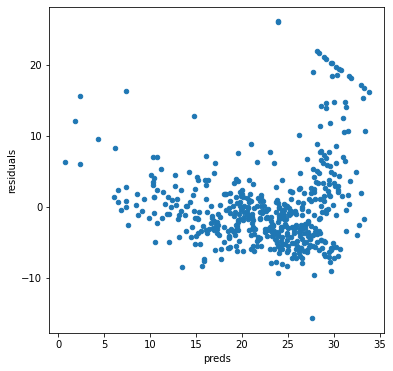

In [69]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":model_lasso.predict(train), "true":target})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

### Robust Lasso

In [72]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha = min_alpha_lasso, random_state=1))
score = rmsle_cv(lasso,train,target)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 8.1148 (1.9905)



### Elsatic Net

c:\users\haju1\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_validation.py:515: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
c:\users\haju1\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
c:\users\haju1\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4818.191921802802, tolerance: 3.919148542079209
  positive)
c:\users\haju1\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_validation.py:515: UserWarning: With alpha=0, this algorithm does not converge well. 

Text(0, 0.5, 'rmsle')

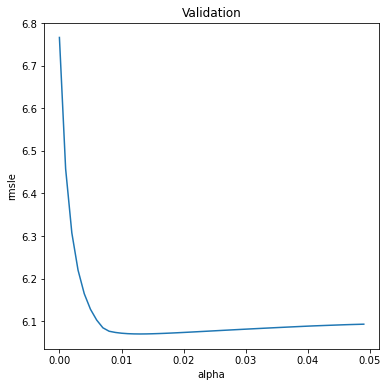

In [76]:
alphas = np.arange(0,0.05,0.001)
cv_en=[]
for alpha in alphas : 
    en = ElasticNet(alpha = alpha)
    cv_en.append(rmsle_cv(en,train,target).mean())
    
cv_en = pd.Series(cv_en, index = alphas)
cv_en.plot(title = "Validation")
plt.xlabel("alpha")
plt.ylabel("rmsle")

In [78]:
cv_min_en = cv_en.min()
print(cv_min_en)
min_alpha_en = np.argmin(cv_en)
min_alpha_en

6.07050880916795


13

Text(0.5, 1.0, 'Coefficients in the EN Model')

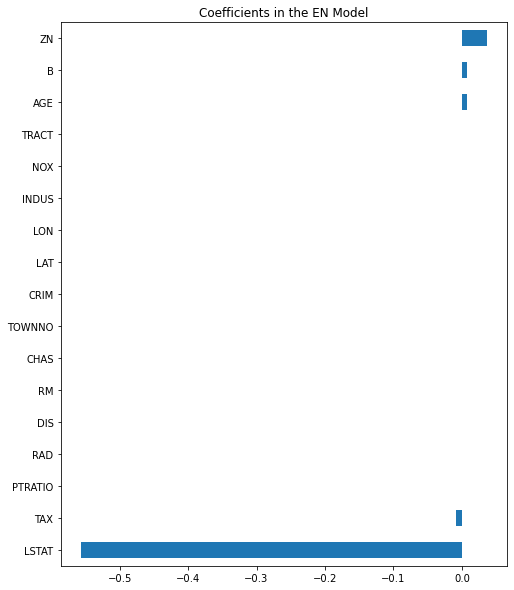

In [80]:
model_en = ElasticNetCV(alphas = [min_alpha_en]).fit(train, target)
coef = pd.Series(model_en.coef_, index = train.columns)
imp_coef = pd.concat([coef.sort_values()])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the EN Model")

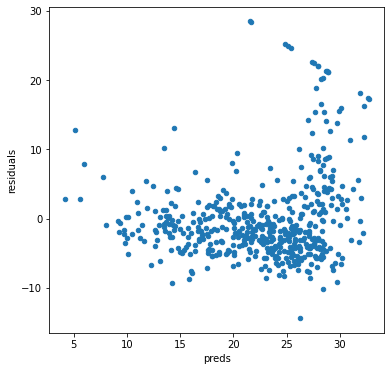

In [82]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":model_en.predict(train), "true":target})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

### XGBOOST

In [83]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [84]:
print(rmsle_cv(model_xgb,train,target))
model_xgb.fit(train, target)
xgb_train_pred = model_xgb.predict(train)

[2.52034187 3.43705409 3.919037   6.80260812 3.59859113]


### LightGBM

In [85]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [86]:
print(rmsle_cv(model_lgb,train,target))
model_lgb.fit(train, target)
lgb_train_pred = model_lgb.predict(train)

[2.66004635 3.51929151 3.87762165 6.16691671 3.619652  ]
